In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "45"
os.environ["NUMBA_NUM_THREADS"] = "45"

# Grab optimized parameters and see what the patterns are

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

np.set_printoptions(precision=8)

In [3]:
df_mf = pd.read_json("../qokit/assets/best_known_QAOA_parameters_wrt_MF.json", orient="index")
df_o = pd.read_json("../qokit/assets/best_known_QAOA_parameters_wrt_overlap.json", orient="index")

### Grab params

In [12]:
N = 22
p = 30

row_mf = df_mf[(df_mf["N"] == N) & (df_mf["p"] == p)].squeeze()
row_o = df_o[(df_o["N"] == N) & (df_o["p"] == p)].squeeze()

x = np.arange(-p / 2 + 0.5, p / 2)
b_m = -np.array(row_mf["beta"])
b_o = -np.array(row_o["beta"])
g_m = np.array(row_mf["gamma"])
g_o = np.array(row_o["gamma"])

beta3 coeffs:  [ 2.64386630e-04  1.01092162e-03 -9.79950909e-03  1.39876685e+00]
beta5 coeffs:  [ 7.36065529e-07  9.51299349e-06  8.18014858e-05 -8.14893634e-04
 -1.07814977e-03  1.43958825e+00]
gamma3 coeffs:  [ 2.64386630e-04  1.01092162e-03 -9.79950909e-03  1.39876685e+00]
gamma5 coeffs:  [ 7.36065529e-07  9.51299349e-06  8.18014858e-05 -8.14893634e-04
 -1.07814977e-03  1.43958825e+00]


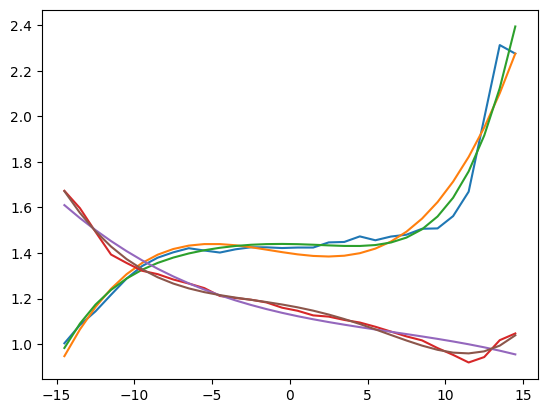

In [13]:
# Compute cubic and quintic transfercoefficients for beta and gamma
ratio_beta = np.array(b_o / b_m)
b3 = np.polyfit(x, ratio_beta, 3)
b5 = np.polyfit(x, ratio_beta, 5)

plt.plot(x, ratio_beta)
plt.plot(x, b3[0] * x**3 + b3[1] * x**2 + b3[2] * x**1 + b3[3])
plt.plot(x, b5[0] * x**5 + b5[1] * x**4 + b5[2] * x**3 + b5[3] * x**2 + b5[4] * x + b5[5])

print("beta3 coeffs: ", b3)
print("beta5 coeffs: ", b5)

ratio_gamma = np.array(g_o / g_m)
g3 = np.polyfit(x, ratio_gamma, 3)
g5 = np.polyfit(x, ratio_gamma, 5)

plt.plot(x, ratio_gamma)
plt.plot(x, g3[0] * x**3 + g3[1] * x**2 + g3[2] * x**1 + g3[3])
plt.plot(x, g5[0] * x**5 + g5[1] * x**4 + g5[2] * x**3 + g5[3] * x**2 + g5[4] * x + g5[5])

print("gamma3 coeffs: ", b3)
print("gamma5 coeffs: ", b5)

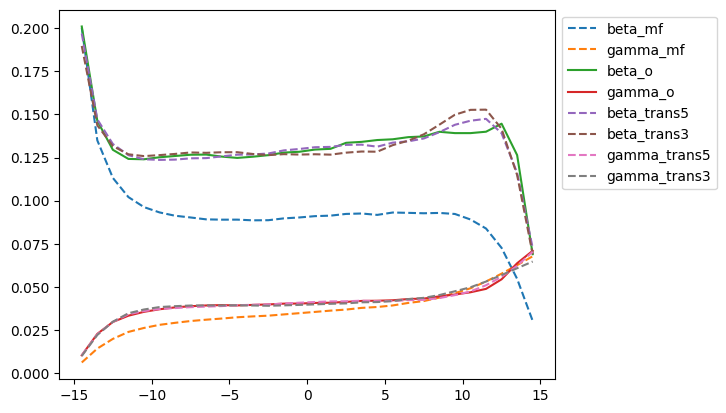

In [14]:
# Plot the original (optimized)
plt.plot(x, -np.array(row_mf["beta"]), label="beta_mf", linestyle="dashed")
plt.plot(x, row_mf["gamma"], label="gamma_mf", linestyle="dashed")
plt.plot(x, -np.array(row_o["beta"]), label="beta_o")
plt.plot(x, np.array(row_o["gamma"]), label="gamma_o")

# Compute the cubit and quintic multipliers
beta_coeffs5 = b5[0] * x**5 + b5[1] * x**4 + b5[2] * x**3 + b5[3] * x**2 + b5[4] * x + b5[5]
beta_coeffs3 = b3[0] * x**3 + b3[1] * x**2 + b3[2] * x + b3[3]
gamma_coeffs5 = g5[0] * x**5 + g5[1] * x**4 + g5[2] * x**3 + g5[3] * x**2 + g5[4] * x + g5[5]
gamma_coeffs3 = g3[0] * x**3 + g3[1] * x**2 + g3[2] * x + g3[3]

# Plot the transferred parameters
plt.plot(x, -np.array(row_mf["beta"]) * (beta_coeffs5), label="beta_trans5", linestyle="dashed")
plt.plot(x, -np.array(row_mf["beta"]) * (beta_coeffs3), label="beta_trans3", linestyle="dashed")

plt.plot(x, np.array(row_mf["gamma"]) * (gamma_coeffs5), label="gamma_trans5", linestyle="dashed")
plt.plot(x, np.array(row_mf["gamma"]) * (gamma_coeffs3), label="gamma_trans3", linestyle="dashed")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

In [16]:
gamma_coeffs5

array([1.67147425, 1.57619609, 1.49560512, 1.42843246, 1.37332318,
       1.32886031, 1.29358876, 1.26603937, 1.24475284, 1.22830373,
       1.21532442, 1.20452911, 1.19473778, 1.18490018, 1.17411981,
       1.16167788, 1.14705731, 1.12996671, 1.11036435, 1.08848211,
       1.06484951, 1.04031767, 1.01608327, 0.99371254, 0.97516526,
       0.96281869, 0.9594916 , 0.96846823, 0.99352224, 1.03894074])

### Test your idea

In [7]:
# def get_overlap_params_from_mf(gamma_mf, beta_mf):
#     beta_coeffs5 = np.array([0.95324617, 1.06819101, 1.15874596, 1.22970268, 1.285122  ,
#            1.32839394, 1.36229767, 1.3890616 , 1.41042334, 1.42768971,
#            1.44179679, 1.45336989, 1.4627836 , 1.47022177, 1.47573755,
#            1.47931337, 1.48092099, 1.48058148, 1.47842527, 1.4747521 ,
#            1.47009109, 1.46526075, 1.46142895, 1.46017296, 1.46353947,
#            1.47410458, 1.49503384, 1.53014223, 1.58395421, 1.66176368,
#            1.76969405, 1.91475821, 2.10491856, 2.34914704, 2.6574851 ])

#     gamma_coeffs5 = np.array([1.85551878, 1.73174156, 1.62624761, 1.53742448, 1.46366128,
#            1.40335846, 1.35493757, 1.31685102, 1.28759181, 1.26570335,
#            1.24978917, 1.23852269, 1.23065699, 1.22503456, 1.22059708,
#            1.21639515, 1.21159808, 1.2055036 , 1.1975477 , 1.18731431,
#            1.17454512, 1.15914928, 1.14121322, 1.12101038, 1.09901096,
#            1.07589172, 1.05254568, 1.03009193, 1.00988537, 0.99352647,
#            0.98287105, 0.98003999, 0.98742905, 1.00771858, 1.04388332])
    
#     return np.array(gamma_mf) * gamma_coeffs5, np.array(beta_mf) * beta_coeffs5

In [17]:
def get_overlap_params_from_mf(gamma_mf, beta_mf):
    beta_coeffs5 = np.array([0.98323202, 1.090287  , 1.1735909 , 1.23814123, 1.28805969,
       1.32668055, 1.35663892, 1.37995913, 1.39814302, 1.4122583 ,
       1.42302684, 1.43091303, 1.43621211, 1.43913845, 1.43991394,
       1.43885629, 1.43646734, 1.43352142, 1.43115365, 1.43094831,
       1.4350271 , 1.44613754, 1.46774124, 1.50410228, 1.56037549,
       1.64269481, 1.75826159, 1.91543296, 2.12381011, 2.39432664])

    gamma_coeffs5 = np.array([1.67147425, 1.57619609, 1.49560512, 1.42843246, 1.37332318,
       1.32886031, 1.29358876, 1.26603937, 1.24475284, 1.22830373,
       1.21532442, 1.20452911, 1.19473778, 1.18490018, 1.17411981,
       1.16167788, 1.14705731, 1.12996671, 1.11036435, 1.08848211,
       1.06484951, 1.04031767, 1.01608327, 0.99371254, 0.97516526,
       0.96281869, 0.9594916 , 0.96846823, 0.99352224, 1.03894074])
    
    return np.array(gamma_mf) * gamma_coeffs5, np.array(beta_mf) * beta_coeffs5

# Transfer MF parameters first, then compute overlap

In [22]:
N_donor = 22
p = 30
row_mf = df_mf[(df_mf["N"] == N_donor) & (df_mf["p"] == p)].squeeze()

beta_donor = row_mf["beta"]
gamma_donor = np.array(row_mf["gamma"]) * N_donor

for N in range(16, 33):
    
    outpath = f"tmp/transfer_scale_{N_donor}_{N}_{p}.pickle"
    if Path(outpath).exists():
        print(f"Found precomputed pickle at {outpath}, skipping", flush=True)
        continue
    
    f = get_qaoa_labs_objective(N, p, parameterization="gamma beta", objective="overlap")

    gamma_transf, beta_transf = get_overlap_params_from_mf(gamma_donor / N, beta_donor)
    o_transf = 1-f(gamma_transf, beta_transf)
    
    print(f"{N}\t{p} overlap transferred: {o_transf:.4f}")
    
    row_out = {
        "N" : N,
        "p" : p,
        "beta_donor" : beta_donor,
        "gamma_donor" : gamma_donor,
        "beta_transf" : beta_transf,
        "gamma_transf" : gamma_transf,
        "overlap transferred" : o_transf,
    }
    
    pickle.dump(row_out, open(outpath, 'wb'))
    
    row_o = df_o[(df_o["N"] == N) & (df_o["p"] == p)]
    if len(row_o) > 0:
        row_o = row_o.squeeze()
        print(f"Expecting: {row_o['overlap']:.4f}, ratio vs directly optimized: {o_transf / row_o['overlap']:.4f}")

/opt/omniai/work/instance1/jupyter/jpmc-argonne-quantum-optimization/jupyter/../code/objectives.py:187: UserWarning: CUDA is NOT available, using cfurx simulator
  warnings.warn(f"CUDA is NOT available, using {simulator} simulator")


16	30 overlap transferred: 0.1172
Expecting: 0.2366, ratio vs directly optimized: 0.4952
17	30 overlap transferred: 0.0389
Expecting: 0.2235, ratio vs directly optimized: 0.1741
18	30 overlap transferred: 0.1846
Expecting: 0.1919, ratio vs directly optimized: 0.9624
19	30 overlap transferred: 0.0738
Expecting: 0.0770, ratio vs directly optimized: 0.9580
20	30 overlap transferred: 0.0279
Expecting: 0.0386, ratio vs directly optimized: 0.7233
21	30 overlap transferred: 0.0067
Expecting: 0.0241, ratio vs directly optimized: 0.2774
22	30 overlap transferred: 0.0569
Expecting: 0.0573, ratio vs directly optimized: 0.9924
23	30 overlap transferred: 0.0156
Expecting: 0.0245, ratio vs directly optimized: 0.6350
24	30 overlap transferred: 0.0044
Expecting: 0.0177, ratio vs directly optimized: 0.2495
25	30 overlap transferred: 0.0012
26	30 overlap transferred: 0.0088
27	30 overlap transferred: 0.0002
Expecting: 0.0039, ratio vs directly optimized: 0.0549
28	30 overlap transferred: 0.0004
Expectin

## TODO: this fit must be scale-dependent

In [3]:
newrows = []
for fname in Path("tmp/").glob("transfer_scale_22_*_30.pickle"):
    row = pickle.load(open(fname, "rb"))
    newrows.append(row)
        
df_transf = pd.DataFrame(newrows, columns=newrows[0].keys()).sort_values('N')

In [4]:
import statsmodels.api as sm

def plot_scaling(dftmp, p, max_n = 32, min_n = 24):
    df_gurobi = pd.read_csv(
        "../qokit/assets/classical_solvers/gurobi_TTS_LABS_Threads_8_Cuts_0_Heuristics_0.csv"
    )

    dftmp['TTS'] = 1 / dftmp['overlap transferred']

    dftmp = dftmp[(dftmp['p'] == p) & (dftmp['N'] >= min_n) & (dftmp['N'] <= max_n)]

    plt.plot(dftmp['N'].values, dftmp['TTS'].values, c='b', label='QAOA')

    X = sm.add_constant(dftmp['N'].values)

    mod = sm.OLS(np.log(dftmp['TTS'].values), X)
    res = mod.fit()
    pred = res.get_prediction(X)

    plt.plot(dftmp['N'].values, np.e**pred.predicted_mean, c='b', linestyle='dashed',
             label=f'QAOA fit:  {np.e**res.params[1]:.3f}**N, +-sigma ({np.e**(res.params[1]-res.bse[1]):.3f}, {np.e**(res.params[1]+res.bse[1]):.3f})')


    df_gurobi = df_gurobi[(df_gurobi['n'] >= dftmp['N'].min()) & (df_gurobi['n'] <= dftmp['N'].max())]
    df_gurobi['TTS scaled'] = dftmp['TTS'].values[0] * df_gurobi["TTS_process_time"] / df_gurobi["TTS_process_time"].values[0]

    plt.plot(dftmp['N'].values, df_gurobi['TTS scaled'].values, c='orange', label='Gurobi')

    mod = sm.OLS(np.log(df_gurobi['TTS scaled'].values), X)
    res = mod.fit()
    pred = res.get_prediction(X)

    plt.plot(dftmp['N'].values, np.e**pred.predicted_mean, c='orange', linestyle='dashed',
             label=f'Gurobi fit:  {np.e**res.params[1]:.3f}**N, +-sigma ({np.e**(res.params[1]-res.bse[1]):.3f}, {np.e**(res.params[1]+res.bse[1]):.3f})')

    plt.xlabel('N')
    plt.yscale('log')
    plt.title(f"p={p}")
    plt.legend()

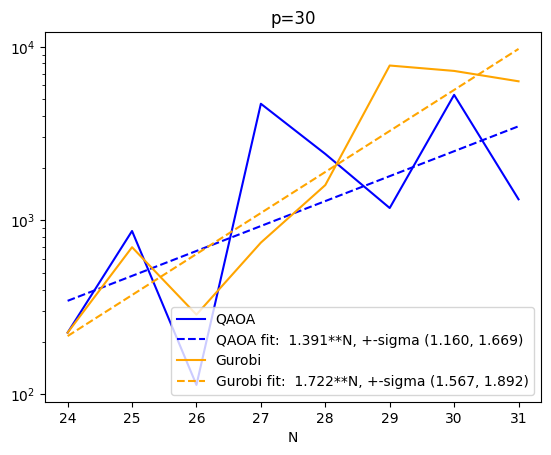

In [8]:
plot_scaling(df_transf, 30, max_n = 31, min_n = 24)

# Train transfer scheme?

In [15]:
from scipy.optimize import minimize

def get_batch_loss_objective(N_min, N_max, p):
    """Inclusive of N_min and N_max
    kwargs are passed directly to get_qaoa_labs_objective
    """
    assert N_min <= N_max
    
    # Finding a scaling rule to transfer from N = 22
    N_donor = 22
    row_mf = df_mf[(df_mf["N"] == N_donor) & (df_mf["p"] == p)].squeeze()
    beta_donor = np.array(row_mf["beta"])
    gamma_donor = np.array(row_mf["gamma"]) * N_donor

    all_fs = []

    for N in range(N_min, N_max + 1):
        all_fs.append((N, get_qaoa_labs_objective(N, p, parameterization='gamma beta', objective="overlap")))

    def batch_f(theta):
        print(theta)
        gamma_coeff = theta[:p]
        beta_coeff = theta[p:]
        gamma = gamma_donor * gamma_coeff
        beta = beta_donor * beta_coeff
        # weighing the higher Ns more as overlap is expected to decay exponentially
        loss = sum(-f(gamma/N, beta) * (1.5**(N-N_min)) for N,f in all_fs) / len(all_fs)
        print(loss)
        return loss

    return batch_f

p = 10
batch_loss = get_batch_loss_objective(18,22,p)

# next line takes forever!
res = minimize(batch_loss, np.ones(2*p), method='COBYLA')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6292553711322775
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6292510799755124
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6299835525043997
[1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.632890071196668
[1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.635708666456183
[1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6363076631189157
[1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6359511060585143
[1. 2. 2. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6361691682001096
[1. 2. 2. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6361472443214247
[1. 2. 2. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6363192625684118
[1. 2. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.636400849922069
[1. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-2.6369072789274646
[1. 2. 2. 2. 2. 1. 

In [16]:
res

     fun: -2.6374997490498417
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([0.99699983, 2.24690491, 3.03911579, 2.77575949, 2.78506047,
       0.13611756, 0.97502152, 0.7388274 , 1.94497879, 1.92521323,
       2.8099639 , 0.16950589, 0.11156938, 1.00259503, 0.82436236,
       0.79255722, 1.45060855, 1.43833541, 2.43994854, 2.52929391])